# Importing lib

In [1]:
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
import warnings
warnings.filterwarnings("ignore")

# Constant values

In [2]:
SIZE = 256
SEED_TRAINING = 121
SEED_TESTING = 197
SEED_VALIDATION = 164
CHANNELS = 3
n_classes = 3
EPOCHS = 50
BATCH_SIZE = 16
input_shape = (SIZE, SIZE, CHANNELS)

# Train, Test and valid data preprocessing 

### Train data augmentation

In [13]:
train_datagen = ImageDataGenerator(
        rescale = 1./255,
        rotation_range = 30,
        shear_range = 0.2,
        zoom_range = 0.2,
        width_shift_range=0.05,
        height_shift_range=0.05,
        horizontal_flip = True,
        fill_mode = 'nearest')

In [14]:
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

### Loading Dataset

In [15]:
train_generator = train_datagen.flow_from_directory(
        directory = 'dataset/train/',  
        target_size = (256, 256),
        batch_size = BATCH_SIZE,
        class_mode = 'categorical',
        color_mode="rgb")
validation_generator = validation_datagen.flow_from_directory(
        'dataset/valid/',
        target_size = (256, 256),
        batch_size = BATCH_SIZE,
        class_mode='categorical',
        color_mode="rgb")
test_generator = test_datagen.flow_from_directory(
        'dataset/test/',
        target_size = (256, 256),
        batch_size = BATCH_SIZE,
        class_mode = 'categorical',
        color_mode = "rgb"
)

Found 1290 images belonging to 3 classes.
Found 430 images belonging to 3 classes.
Found 430 images belonging to 3 classes.


# Pre-defined CNN architecture

In [ ]:
from keras.applications import VGG16
from keras.applications import VGG19
from tensorflow.keras.applications import EfficientNetB0
from keras.applications import ResNet50

vgg16 = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
for layer in vgg16.layers:
    layer.trainable = False
    
vgg19 = VGG19(include_top=False, weights='imagenet', input_shape=input_shape)
for layer in vgg19.layers:
    layer.trainable = False

effnet = EfficientNetB0(include_top=False, weights='imagenet', input_shape=input_shape)
for layer in effnet.layers:
    layer.trainable = False

resnet = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
for layer in resnet.layers:
    layer.trainable = False

models = {"VGG16":vgg16, "VGG19":vgg19, "Efficient Net":effnet, "Res Net":resnet} 

In [7]:
def train_model(model, name):
    print("Traning", name)
    x = model.output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(3, activation='softmax')(x)
    model = Model(inputs=model.input, outputs=predictions)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    history = model.fit(
            train_generator,
            steps_per_epoch = train_generator.n//train_generator.batch_size,
            epochs = EPOCHS,
            validation_data = validation_generator,
            validation_steps = validation_generator.n//validation_generator.batch_size
            )
    score = model.evaluate(test_generator)
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(range(EPOCHS), acc, label='Training Accuracy')
    plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.subplot(1, 2, 2)
    plt.plot(range(EPOCHS), loss, label='Training Loss')
    plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()
    model.save(f'{name}.keras')
    print(name, score)
    return score

In [ ]:
score = {}
for key, val in models.items():
    score[key] = train_model(val, key)
print(score)

# Enhanced VGG16 architecture

In [16]:
model = keras.models.Sequential([
        keras.layers.Conv2D(32, (3,3), activation = 'relu', input_shape = input_shape),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Dropout(0.5),
        keras.layers.Conv2D(64, (3,3), activation = 'relu', padding = 'same'),
        keras.layers.MaxPooling2D((2,2)),
        keras.layers.Dropout(0.5),
        keras.layers.Conv2D(64, (3,3), activation = 'relu', padding = 'same'),
        keras.layers.MaxPooling2D((2,2)),
        keras.layers.Conv2D(64, (3,3), activation = 'relu', padding = 'same'),
        keras.layers.MaxPooling2D((2,2)),
        keras.layers.Conv2D(64, (3,3), activation = 'relu', padding = 'same'),
        keras.layers.MaxPooling2D((2,2)),
        keras.layers.Conv2D(64, (3,3), activation = 'relu', padding = 'same'),
        keras.layers.MaxPooling2D((2,2)),
        keras.layers.Flatten(),
        keras.layers.Dense(32, activation ='relu'),
        keras.layers.Dense(n_classes, activation='softmax')
    ])

In [17]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 127, 127, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 63, 63, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 63, 63, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 63, 63, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 31, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 31, 31, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 15, 15, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 7, 7, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 185,667 (725.26 KB)

 Trainable params: 185,667 (725.26 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
model.compile(
    optimizer = 'adam',
    loss = keras.losses.CategoricalCrossentropy(),
    metrics  = ['accuracy']
    )

In [22]:
history = model.fit(
        train_generator,
        steps_per_epoch = train_generator.n//train_generator.batch_size,
        epochs = EPOCHS,
        validation_data = validation_generator,
        validation_steps = validation_generator.n// validation_generator.batch_size
        )

Epoch 1/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 37s 442ms/step - accuracy: 0.6006 - loss: 0.8535 - val_accuracy: 0.7308 - val_loss: 0.8120
Epoch 2/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6875 - loss: 0.4028 - val_accuracy: 0.6429 - val_loss: 0.4544
Epoch 3/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 33s 409ms/step - accuracy: 0.7419 - loss: 0.6062 - val_accuracy: 0.8558 - val_loss: 0.4050
Epoch 4/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8750 - loss: 0.2504 - val_accuracy: 0.7857 - val_loss: 0.2155
Epoch 5/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 34s 410ms/step - accuracy: 0.8222 - loss: 0.4254 - val_accuracy: 0.8918 - val_loss: 0.2982
Epoch 6/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step - accuracy: 0.9375 - loss: 0.0767 - val_accuracy: 1.0000 - val_loss: 0.1235
Epoch 7/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 33s 407ms/step - accuracy: 0.8601 - loss: 0.3216 - val_accuracy: 0.9087 - val_loss: 0.2720
Epoch 8/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step - accuracy: 1.0000 - loss: 0.0484 - val_accuracy: 0

# Model evalutation

In [23]:
score = model.evaluate(test_generator)
print("Evaluation score:", score)

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.9833 - loss: 0.0786
Evaluation score: [0.07895561307668686, 0.9837209582328796]


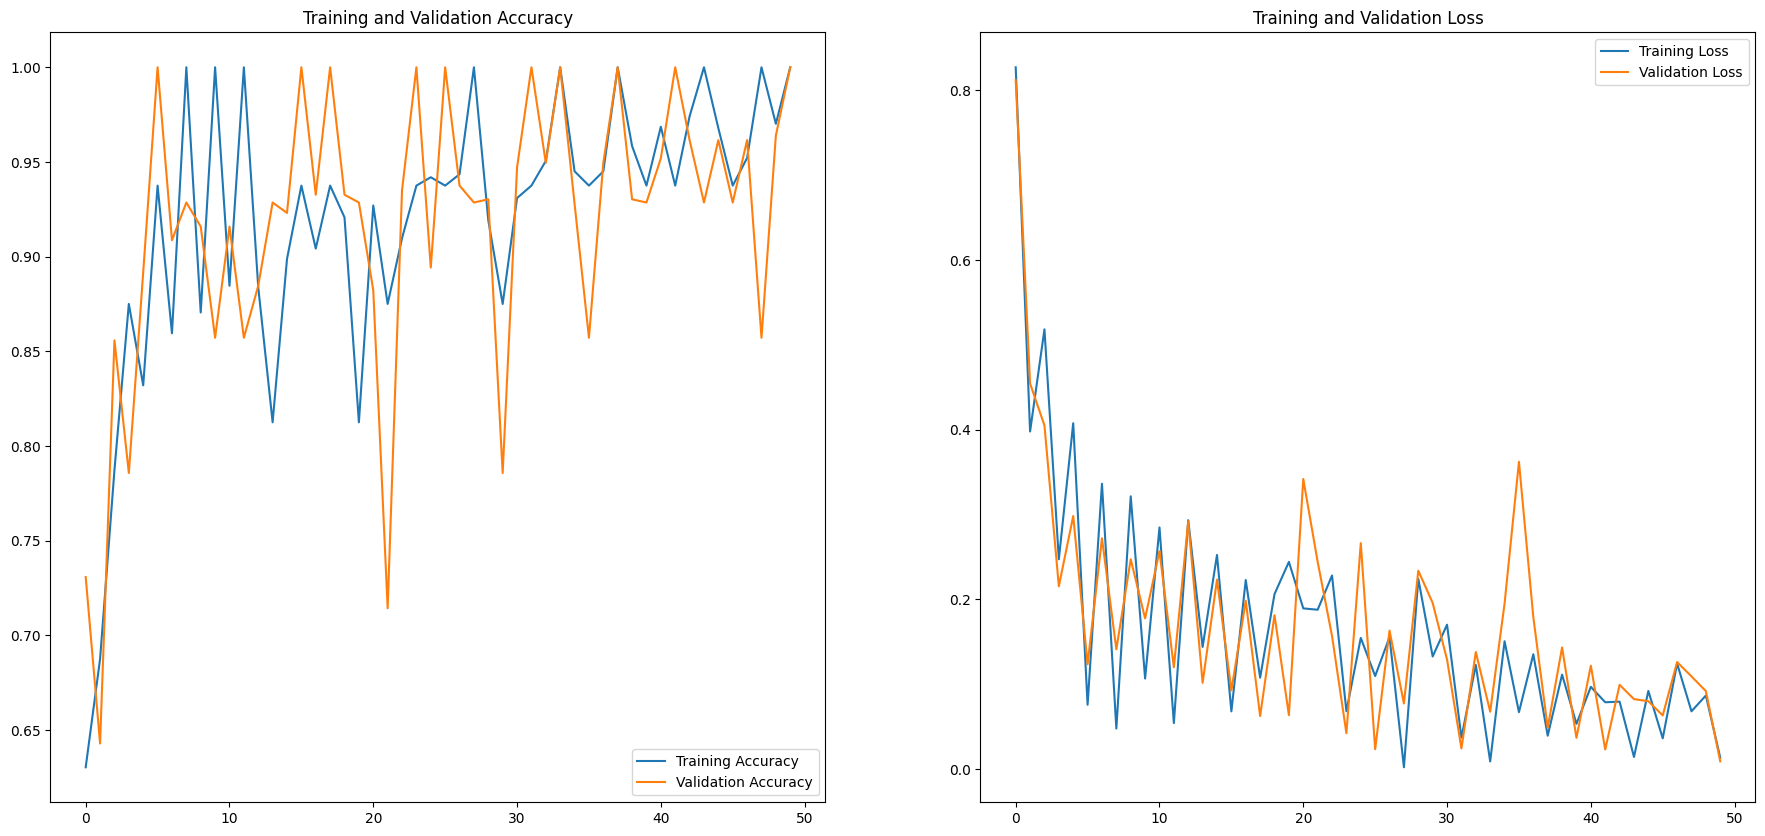

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
fig = plt.figure(figsize=(22, 10))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
fig.savefig("trainaccuracy.svg")
model.save('classification.keras')